# Теоретические вопросы
## Для чего и в каких случаях полезны различные варианты усреднения для метрик качества классификации: micro, macro, weighted?
**Ответ:** 
1. **micro** - используется для оценки метрик в несбалансироанных данных в которых не важна разница весов классов. 
2. **macro** - простое арифмитическое среднее между f1-оценками разных классов. Общая оценка модели.
3. **weighted** - расчет метрики с учетом весов каждого класса (их численности). Оценка несбалансированной модели в которой важна разница весов классов.

## В чём разница между моделями xgboost, lightgbm и catboost или какие их основные особенности?
**Ответ:** 
1. **xgboost** - давольно старый алгоритм, работает медненно, но точно. Не работает с категориальными данными.
2. **lightgbm** - новая модель, способная принимать категориальные данные, но только в числовом формате. Работает быстро, но не идеально.
3. **catboost** - новейшая модель, способна принимать категориальные данные, как в числовом, так и в строковом формате. Работает давольно быстро, если правильно настроена, результаты сравнимы с xgboost.

# Построение моделей классификации

### Описание датасета 
**подпункты с описанием добавленных столбцов после подготовки**


* **Home Ownership** - домовладение
        
        1. разложен на дамми переменные
    
* **Annual Income** - годовой доход
        
        1. Annual Income upd.2 - пропуски заполены мединой
        2. Annual Income upd.3 - пропуски заполнены моделью (близжайшие соседи)
        
* **Years in current job** - количество лет на текущем месте работы

        1. upd2 - замененные на числовые значения и заполненные модой
        2. дамми переменные заполненные модой
        3. upd.3 - пропуски заполнены моделью (близжайшие соседи)
        
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
        
        1. upd.2 - пропуски заполены модой
        2. upd.3 - пропуски заполнены моделью (близжайшие соседи)
        
* **Purpose** - цель кредита
        
        1. разложен на дамми переменные
  
* **Term** - срок кредита
        
        1. разложен на дамми переменные
  
* **Current Loan Amount** - текущая сумма кредита
        
        1. ver.2 - выбросы заполены регрессией
        
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)
* **Credit Score** - кредитные очки
        
        1. ver.2 - убраны выбросы и заполнены пропуски с помощью модели
        2. ver.3 - убраны выбросы и заполнены пропуски медианой
        3. ver.4 - убраны выбросы и пропуски заполнены моделью (близжайшие соседи)

## Описание групп признаков

* TARGET_NAME - целевая переменная
* full_features_list - все признаки без пропусков
* num_features - числовые признаки
* cat_features_str - категориальные признаки (со стороквыми для **CatBoost**)
* cat_features_dumm_years_dummy - категориальные признаки разбитые на дамми переменные где "Years in current job" тоже разбит
* cat_features_dumm_years_one - категориальные признаки разбитые на дамми переменные где "Years in current job" заменен на числовые значения
* cat_features_str_to_int - категориальные признаки (где значения заменены на цифры для **LightGBM**)

# Подключаем библиотеки

In [2161]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import random

from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
from imblearn.under_sampling import TomekLinks, OneSidedSelection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix


from sklearn.linear_model import LogisticRegression, RidgeClassifier

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb


%matplotlib inline

In [2162]:
import warnings
warnings.simplefilter('ignore')

In [2163]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [2164]:
# 3.4. Пользовательские функции
def parse_params(param_grid, model_label):
    param_dict = dict()
    for key, value in param_grid.items():
        param_dict[model_label+"__"+key] = value
    return param_dict


def show_proba_calibration_plots(y_predicted_probs, y_true_labels, p_min, p_max, p_step):
    y_predicted_probs = y_predicted_probs[:,1]
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(p_min, p_max, p_step):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
    
def update_predict_by_prob(y_true, predict_probas, prob_min, prob_max, prob_steps, score='f1', show_chart=False):
    if score=='f1':
        score_estimator = f1_score
    elif score=='accuracy':
        score_estimator = accuracy_score
    else:
        print('wrong score name')
        return None
    prob_range = np.linspace(prob_min, prob_max, prob_steps)
    scores = []
    for p in prob_range:
        predict_rebalanced = np.array([1 if x>=p else 0 for x in predict_probas[:,1]])
        scores.append(score_estimator(y_true, predict_rebalanced))
    if show_chart:
        figure = plt.figure(figsize = (5, 4))
        plt.ylabel('Scores')
        plt.xlabel('Probability threshold')
        plt.plot(prob_range, scores, label=score, linewidth=4)
        plt.title("Best Threshold Probability Search")
        plt.show()
    scores = np.array(scores)
    best_prob = prob_range[scores.argmax()]
    print(f'best threshold probability = {best_prob}')
    predict_rebalanced_final = np.array([1 if x>=best_prob else 0 for x in predict_probas[:,1]])
    return predict_rebalanced_final, best_prob

In [2165]:
PATH_COURSE_PROJECT_DATASET_TRAIN_PREP = 'course_project/course_project_train_prep.csv'
PATH_COURSE_PROJECT_DATASET_TRAIN = 'course_project/course_project_train.csv'

PATH_COURSE_PROJECT_DATASET_TEST_PREP = 'course_project/course_project_test_prep.csv'
PATH_COURSE_PROJECT_DATASET_TEST = 'course_project/course_project_test.csv'

SCALER_FILE_PATH = 'scaler.pkl'

TRAIN_FULL_PATH = 'course_project_train_full.csv'
TRAIN_PART_PATH = 'course_project_train_part.csv'
TEST_PART_PATH = 'course_project_test_part.csv'

# Загружаем базы данных
Чистим от не нужных столбцов 

In [2166]:
df_base = pd.read_csv(PATH_COURSE_PROJECT_DATASET_TRAIN)

df_new = pd.read_csv(PATH_COURSE_PROJECT_DATASET_TRAIN_PREP)
df_new.drop('Unnamed: 0', axis=1, inplace=True)

df_test_base = pd.read_csv(PATH_COURSE_PROJECT_DATASET_TEST)
df_test_new = pd.read_csv(PATH_COURSE_PROJECT_DATASET_TEST_PREP)
df_test_new.drop('Unnamed: 0', axis=1, inplace=True)

In [2167]:
df_new['NEW_2_C-P'] = df_new['NEW_2_C-P'].astype(int)

## Преобразуем строковые значения категориальных признаков в числовые для модели LGBM

In [2168]:
dataset_list = [df_new, df_test_new]
for cat in df_new.select_dtypes(include='object').columns.drop('Years in current job'):
    dict_of_values_name = dict()
    repeat_number = 0
    for dataset in dataset_list:
        n = 0
        dataset[f'{cat}_for_LGBM'] = dataset[cat].copy()
        for value_name in dataset[f'{cat}_for_LGBM'].value_counts().index:
            if repeat_number == 0:
                dataset[f'{cat}_for_LGBM'].loc[dataset[f'{cat}_for_LGBM'] == value_name] = n
                dict_of_values_name[value_name] = n
                n += 1
            if repeat_number == 1:
                try:
                    dataset[f'{cat}_for_LGBM'].loc[dataset[f'{cat}_for_LGBM'] == value_name] = dict_of_values_name[value_name]
                except Exception as e:
                    dataset[f'{cat}_for_LGBM'].loc[dataset[f'{cat}_for_LGBM'] == value_name] = dict_of_values_name['other']  
        dataset[f'{cat}_for_LGBM'] = dataset[f'{cat}_for_LGBM'].astype('int64')
    repeat_number +=1

## Округляем значения Credit Score ver.2 для возможного использования признака как категориального

In [2169]:
df_new['Credit Score ver.2'] = round(df_new['Credit Score ver.2'])

In [2170]:
# Длинна позволяет (до 255)
len(df_new['Credit Score ver.2'].value_counts().index)

158

## Проверяем соответствие тествого и тренеровочного датасетов по признакам

In [2171]:
new_fearures_list = df_test_new.columns.tolist()

In [2172]:
new_fearures_list = df_test_new.columns.tolist()
for i in df_new.columns.tolist():
    try:
        new_fearures_list.remove(i)
    except:
        print(i)

new_fearures_list = df_new.columns.tolist()
for i in df_test_new.columns.tolist():
    try:
        new_fearures_list.remove(i)
    except:
        print(i)

Credit Default


## Распределяем признаки по моделям

In [2173]:
TARGET_NAME = 'Credit Default'

In [2174]:
full_features_list = [col for col in df_new.columns.tolist() if df_new[col].isnull().sum() == 0]

In [2175]:
# тест без признака number open accounts
full_features_list.remove('Number of Open Accounts')

In [2176]:
num_features = df_new[full_features_list].select_dtypes(include=['float']).columns.tolist()

In [2177]:
for i in ['pca_1_H-O_OH_R', 'pca_2_H-O_OH_R', 'Credit Score ver.3', 'Annual Income upd.2', 'Current Loan Amount']:
    num_features.remove(i)
    
for i in ['Credit Score ver.2', 'Bankruptcies upd.2']:
    num_features.remove(i)


In [2178]:
num_features

['Tax Liens',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Monthly Debt',
 'Current Loan Amount ver.2',
 'Annual Income upd.3',
 'Credit Score ver.4',
 'Bankruptcies upd.3',
 'Years in current job upd.3']

In [2179]:
cat_features_str = df_new[full_features_list].select_dtypes(include=['object', 'category']).columns.tolist()
cat_features_str.append('NEW_1_H-O')
cat_features_str.remove('Home Ownership')
cat_features_str.remove('Years in current job')
cat_features_str

['Purpose', 'Term', 'NEW_1_H-O']

In [2180]:
cat_features_dumm_years_dummy = df_new[full_features_list].drop(TARGET_NAME, axis=1).select_dtypes(include=['int']).columns.tolist()[:-3]
# cat_features_dumm_years_one = cat_features_dumm_years_dummy[:-10]
cat_features_dumm_years_dummy.remove('Years in current job upd.2')

In [2181]:
cat_features_dumm_years_one = cat_features_dumm_years_dummy

for el in cat_features_dumm_years_dummy[-11:-1]:
    cat_features_dumm_years_one.remove(el)
cat_features_dumm_years_one.remove('NEW_2_C-P')

In [2182]:
full_features_list_2 = full_features_list
for el in cat_features_str:
    full_features_list_2.remove(el)
full_features_list_2.remove('Home Ownership')  

In [2183]:
lr_features = num_features+ cat_features_dumm_years_one + ['Years in current job_< 1 year', 'pca_1_H-O_OH_R', 'pca_2_H-O_OH_R']
lr_cat_features = cat_features_dumm_years_one + ['Years in current job_< 1 year', 'pca_1_H-O_OH_R', 'pca_2_H-O_OH_R']

In [2184]:
lr_cat_features

['Term_Short Term',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_10+ years',
 'Years in current job_< 1 year',
 'pca_1_H-O_OH_R',
 'pca_2_H-O_OH_R']

In [2185]:
features_for_bal = lr_features + ['Term', 'Purpose', 'NEW_1_H-O']

In [2186]:
cat_features_str_to_int = full_features_list[-3:]
cat_features_str_to_int.append('Years in current job upd.2')

In [2187]:
all_categorical_features = cat_features_str_to_int + cat_features_str + cat_features_dumm_years_dummy

In [2188]:
ready_features_list = num_features + all_categorical_features

In [2189]:
cat_features_str_to_int

['Home Ownership_for_LGBM',
 'Purpose_for_LGBM',
 'Term_for_LGBM',
 'Years in current job upd.2']

## Приведение типов для модели  CatBoost

In [2190]:
for colname in cat_features_str:
    df_new[colname] = pd.Categorical(df_new[colname])
    
df_new[cat_features_str].dtypes

catB_features = num_features + cat_features_str

## Нормализация данных

In [2191]:
num_features2 = num_features.copy()
# num_features2.remove('Credit Score ver.2')

scaler = StandardScaler()

df_norm = df_new.copy()
df_test_norm = df_test_new.copy()

# scaler.fit(df_norm[num_features2])
df_norm[num_features2] = scaler.fit_transform(df_norm[num_features2])
df_test_norm[num_features2] = scaler.transform(df_test_norm[num_features2])

df_new = df_norm.copy()
df_test_new = df_test_norm.copy()

**Сохранение модели для нормализации данных**

In [2192]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [2193]:
catB_features = list(set(catB_features))
all_categorical_features = list(set(all_categorical_features))

In [2194]:
ready_features_list = list(set(ready_features_list))

## Балансировка данных

In [2195]:
sm = SMOTENC(categorical_features=[df_new[lr_features].columns.get_loc(col) for col in lr_cat_features], n_jobs=-1)

**Разбиение на train и test**

In [2196]:
X = df_new[features_for_bal]
y = df_new[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30)

In [2197]:
X_train_res, y_train_res = sm.fit_sample(X_train[lr_features], y_train)


print(f"Before OverSampling, counts of label '1': {sum(y_train==1)}")
print(f"Before OverSampling, counts of label '0': {sum(y_train==0)} \n")
print(f'After OverSampling, the shape of X_train: {X_train_res.shape}')
print(f'After OverSampling, the shape of y_train: {y_train_res.shape} \n')
print(f"After OverSampling, counts of label '1': {sum(y_train_res==1)}")
print(f"After OverSampling, counts of label '0': {sum(y_train_res==0)}")

Before OverSampling, counts of label '1': 1469
Before OverSampling, counts of label '0': 3781 

After OverSampling, the shape of X_train: (7562, 33)
After OverSampling, the shape of y_train: (7562,) 

After OverSampling, counts of label '1': 3781
After OverSampling, counts of label '0': 3781


In [2198]:
adasyn = ADASYN(sampling_strategy='auto', n_jobs=-1)
X_train_ada, y_train_ada = adasyn.fit_sample(X_train[lr_features], y_train)

print(f"Before OverSampling, counts of label '1': {sum(y_train==1)}")
print(f"Before OverSampling, counts of label '0': {sum(y_train==0)} \n")
print(f'After OverSampling, the shape of X_train: {X_train_ada.shape}')
print(f'After OverSampling, the shape of y_train: {y_train_ada.shape} \n')
print(f"After OverSampling, counts of label '1': {sum(y_train_ada==1)}")
print(f"After OverSampling, counts of label '0': {sum(y_train_ada==0)}")

Before OverSampling, counts of label '1': 1469
Before OverSampling, counts of label '0': 3781 

After OverSampling, the shape of X_train: (7399, 33)
After OverSampling, the shape of y_train: (7399,) 

After OverSampling, counts of label '1': 3618
After OverSampling, counts of label '0': 3781


In [2199]:
X_train['ID'] = X_train.index
X['ID'] = X.index

In [2200]:
tomek = TomekLinks(sampling_strategy='auto', n_jobs=-1)
X_train_tom, y_train_tom = tomek.fit_sample(X_train[lr_features + ['ID']], y_train)
X_tom, y_tom = tomek.fit_sample(X[lr_features + ['ID']], y)

print(f"Before OverSampling, counts of label '1': {sum(y_train==1)}")
print(f"Before OverSampling, counts of label '0': {sum(y_train==0)} \n")
print(f'After OverSampling, the shape of X_train: {X_train_tom.shape}')
print(f'After OverSampling, the shape of y_train: {y_train_tom.shape} \n')
print(f"After OverSampling, counts of label '1': {sum(y_train_tom==1)}")
print(f"After OverSampling, counts of label '0': {sum(y_train_tom==0)}")

Before OverSampling, counts of label '1': 1469
Before OverSampling, counts of label '0': 3781 

After OverSampling, the shape of X_train: (4690, 34)
After OverSampling, the shape of y_train: (4690,) 

After OverSampling, counts of label '1': 1469
After OverSampling, counts of label '0': 3221


In [2201]:
oss = OneSidedSelection()

X_train_oss, y_train_oss = oss.fit_sample(X_train[lr_features + ['ID']], y_train)

print(f"Before OverSampling, counts of label '1': {sum(y_train==1)}")
print(f"Before OverSampling, counts of label '0': {sum(y_train==0)} \n")
print(f'After OverSampling, the shape of X_train: {X_train_oss.shape}')
print(f'After OverSampling, the shape of y_train: {y_train_oss.shape} \n')
print(f"After OverSampling, counts of label '1': {sum(y_train_oss==1)}")
print(f"After OverSampling, counts of label '0': {sum(y_train_oss==0)}")

Before OverSampling, counts of label '1': 1469
Before OverSampling, counts of label '0': 3781 

After OverSampling, the shape of X_train: (4688, 34)
After OverSampling, the shape of y_train: (4688,) 

After OverSampling, counts of label '1': 1469
After OverSampling, counts of label '0': 3219


In [2202]:
X_train_oss_tom, y_train_oss_tom = tomek.fit_sample(X_train_oss, y_train_oss)

print(f"Before OverSampling, counts of label '1': {sum(y_train_oss==1)}")
print(f"Before OverSampling, counts of label '0': {sum(y_train_oss==0)} \n")
print(f'After OverSampling, the shape of X_train: {X_train_oss_tom.shape}')
print(f'After OverSampling, the shape of y_train: {y_train_oss_tom.shape} \n')
print(f"After OverSampling, counts of label '1': {sum(y_train_oss_tom==1)}")
print(f"After OverSampling, counts of label '0': {sum(y_train_oss_tom==0)}")

Before OverSampling, counts of label '1': 1469
Before OverSampling, counts of label '0': 3219 

After OverSampling, the shape of X_train: (4480, 34)
After OverSampling, the shape of y_train: (4480,) 

After OverSampling, counts of label '1': 1469
After OverSampling, counts of label '0': 3011


In [2203]:
X_train_oss_CB = X_train.loc[X_train['ID'].isin(X_train_oss['ID'])]
y_train_oss_CB = y_train.loc[X_train_oss_CB.index]

In [2204]:
X_train_tom_CB = X_train.loc[X_train['ID'].isin(X_train_tom['ID'])]
y_train_tom_CB = y_train.loc[X_train_tom_CB.index]

X_train = X_train.drop('ID', axis=1)

In [2205]:
X_tom_CB = X.loc[X['ID'].isin(X_tom['ID'])]
y_tom_CB = y.loc[X_tom_CB.index]
X = X.drop('ID', axis=1)

## Сохранение обучающего и тестового датасета

In [2206]:
train = pd.concat([X_train_oss, y_train_oss], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [2207]:
df_new.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

## Построение и оценка бозовых моделей

### Логистическая регрессия

In [2208]:
n = 0
for prep_dataset in [[X_train_oss_tom, y_train_oss_tom],
                     [X_train_oss, y_train_oss],
                     [X_train_tom, y_train_tom], 
                     [X_train_ada, y_train_ada], 
                     [X_train_res, y_train_res]]:
    
    n += 1
    
    X_train_prep, y_train_prep = prep_dataset[0], prep_dataset[1]
    
    model_lr=LogisticRegression(class_weight={0: 1, 1: 3}, C=5000)
    model_lr.fit(X_train_prep[lr_features], y_train_prep)

    y_train_pred = model_lr.predict(X_train_prep[lr_features])
    y_test_pred = model_lr.predict(X_test[lr_features])

    # get_classification_report(y_train_oss_tom, y_train_pred, y_test, y_test_pred)

    # 3.11.4.калитбровка
    predict_probas = model_lr.predict_proba(X_test[lr_features])
#     show_proba_calibration_plots(predict_probas, y_test, 0.1, 0.8, 20)
    predict2, threshold_prob = update_predict_by_prob(y_test, predict_probas, 0.25, 0.9, 200, score='f1')
    # print(f1_score(y_test, predict))
    # print(f1_score(y_test, predict2))

    # 3.11.5. результаты
    print(70*'-')
    print(f'! - {n} - !')
    # print(f'f1 on valid set = {f1_score(y_test, predict)}')
    print(f'f1 on valid set = {f1_score(y_test, y_test_pred)}')
    print(f'f1 on valid set after calibrating = {f1_score(y_test, predict2)}')
    print(70*'-')
    # get_classification_report(y_train_oss, y_train_pred, y_test, predict2)

best threshold probability = 0.5798994974874372
----------------------------------------------------------------------
! - 1 - !
f1 on valid set = 0.4770975056689342
f1 on valid set after calibrating = 0.4814814814814815
----------------------------------------------------------------------
best threshold probability = 0.48190954773869343
----------------------------------------------------------------------
! - 2 - !
f1 on valid set = 0.4719314938154138
f1 on valid set after calibrating = 0.47910112359550566
----------------------------------------------------------------------
best threshold probability = 0.5537688442211055
----------------------------------------------------------------------
! - 3 - !
f1 on valid set = 0.47315914489311167
f1 on valid set after calibrating = 0.478286734086853
----------------------------------------------------------------------
best threshold probability = 0.6746231155778895
----------------------------------------------------------------------
! -

In [2209]:
model_lr=LogisticRegression(class_weight={0: 1, 1: 3}, C=5000)
model_lr.fit(X_train_tom[lr_features], y_train_tom)

y_train_pred = model_lr.predict(X_train_tom[lr_features])
y_test_pred = model_lr.predict(X_test[lr_features])

get_classification_report(y_train_tom, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.42      0.56      3221
           1       0.38      0.79      0.52      1469

    accuracy                           0.54      4690
   macro avg       0.60      0.61      0.54      4690
weighted avg       0.68      0.54      0.54      4690

TEST

              precision    recall  f1-score   support

           0       0.81      0.40      0.54      1606
           1       0.34      0.77      0.47       644

    accuracy                           0.51      2250
   macro avg       0.58      0.59      0.51      2250
weighted avg       0.68      0.51      0.52      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               643  963
1               146  498


In [2210]:
f1_score(y_test, y_test_pred)

0.47315914489311167

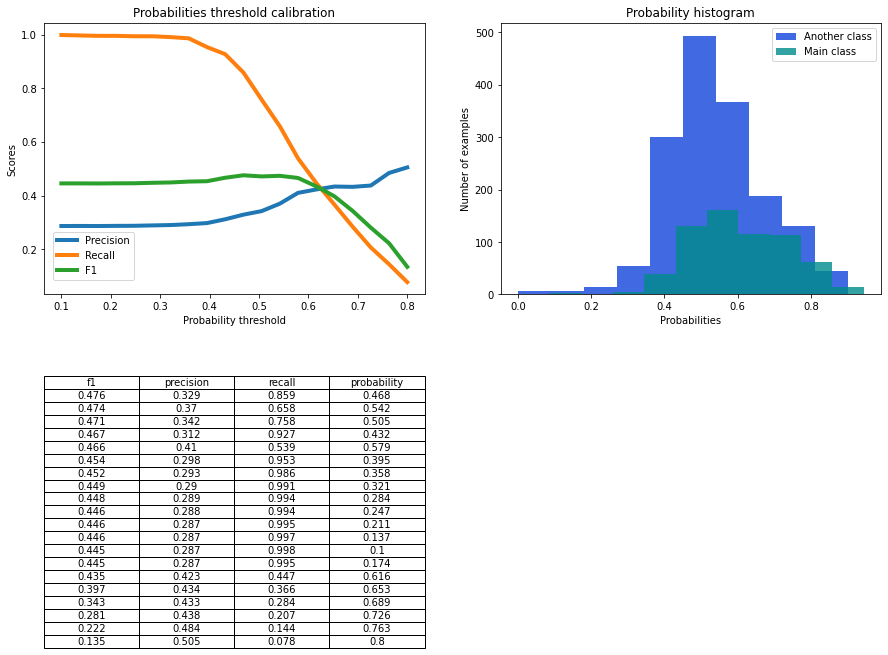

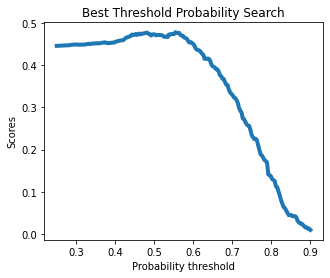

best threshold probability = 0.5537688442211055
----------------------------------------------------------------------
f1 on valid set = 0.47315914489311167
f1 on valid set after calibrating = 0.478286734086853
----------------------------------------------------------------------
TRAIN

              precision    recall  f1-score   support

           0       0.81      0.42      0.56      3221
           1       0.38      0.79      0.52      1469

    accuracy                           0.54      4690
   macro avg       0.60      0.61      0.54      4690
weighted avg       0.68      0.54      0.54      4690

TEST

              precision    recall  f1-score   support

           0       0.80      0.60      0.69      1606
           1       0.39      0.62      0.48       644

    accuracy                           0.61      2250
   macro avg       0.59      0.61      0.58      2250
weighted avg       0.68      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit D

In [2211]:
# 3.11.4.калитбровка
predict_probas = model_lr.predict_proba(X_test[lr_features])
show_proba_calibration_plots(predict_probas, y_test, 0.1, 0.8, 20)
predict2, threshold_prob = update_predict_by_prob(y_test, predict_probas, 0.25, 0.9, 200, score='f1', show_chart=True)
# print(f1_score(y_test, predict))
# print(f1_score(y_test, predict2))

# 3.11.5. результаты
print(70*'-')
# print(f'f1 on valid set = {f1_score(y_test, predict)}')
print(f'f1 on valid set = {f1_score(y_test, y_test_pred)}')
print(f'f1 on valid set after calibrating = {f1_score(y_test, predict2)}')
print(70*'-')
get_classification_report(y_train_tom, y_train_pred, y_test, predict2)

### KNeighbors

In [2212]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_res[cat_features_dumm_years_one + num_features], y_train_res)

y_train_pred = model_knn.predict(X_train_res[cat_features_dumm_years_one + num_features])
y_test_pred = model_knn.predict(X_test[cat_features_dumm_years_one + num_features])

get_classification_report(y_train_res, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      3781
           1       0.76      0.92      0.83      3781

    accuracy                           0.82      7562
   macro avg       0.83      0.82      0.81      7562
weighted avg       0.83      0.82      0.81      7562

TEST

              precision    recall  f1-score   support

           0       0.74      0.60      0.66      1606
           1       0.32      0.48      0.38       644

    accuracy                           0.56      2250
   macro avg       0.53      0.54      0.52      2250
weighted avg       0.62      0.56      0.58      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               959  647
1               338  306


### XGBoost

In [2213]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_res[cat_features_dumm_years_one + num_features], y_train_res)

y_train_pred = model_xgb.predict(X_train_res[cat_features_dumm_years_one + num_features])
y_test_pred = model_xgb.predict(X_test[cat_features_dumm_years_one + num_features])

get_classification_report(y_train_res, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3781
           1       0.96      0.95      0.95      3781

    accuracy                           0.95      7562
   macro avg       0.96      0.95      0.95      7562
weighted avg       0.96      0.95      0.95      7562

TEST

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      1606
           1       0.37      0.33      0.35       644

    accuracy                           0.64      2250
   macro avg       0.55      0.55      0.55      2250
weighted avg       0.64      0.64      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1236  370
1                429  215


### LightGBM

In [2214]:
model_lgbm = lgbm.LGBMClassifier()
model_lgbm.fit(X_train_res[num_features + cat_features_str_to_int], y_train_res, categorical_feature=[df_new[num_features + cat_features_str_to_int].columns.get_loc(col) for col in cat_features_str_to_int])

y_train_pred = model_lgbm.predict(X_train_res[num_features + cat_features_str_to_int])
y_test_pred = model_lgbm.predict(X_test[num_features + cat_features_str_to_int])

get_classification_report(y_train_res, y_train_pred, y_test, y_test_pred)

KeyError: "['Term_for_LGBM', 'Years in current job upd.2', 'Purpose_for_LGBM', 'Home Ownership_for_LGBM'] not in index"

### CatBoost

In [2215]:
importance_features = ['Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Monthly Debt',
 'Current Loan Amount ver.2',
 'Annual Income upd.3',
 'Credit Score ver.4',
 'Years in current job upd.3',
 'Purpose',
 'Term',
 'NEW_1_H-O']

In [2216]:
%%time

model_catb = catb.CatBoostClassifier(silent=True,
                                     n_estimators=300,
                                     one_hot_max_size=15,
                                     learning_rate=0.006,
                                     l2_leaf_reg=2,
#                                      iterations=700,
                                     depth=5,
                                     class_weights=[1, 2.5],
                                     cat_features=cat_features_str_2)

model_catb.fit(X_train_tom_CB[importance_features], y_train_tom_CB, cat_features=cat_features_str_2)

y_train_pred = model_catb.predict(X_train_tom_CB[importance_features])
y_test_pred = model_catb.predict(X_test[importance_features])

get_classification_report(y_train_tom_CB, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.47      0.60      3221
           1       0.40      0.79      0.53      1469

    accuracy                           0.57      4690
   macro avg       0.62      0.63      0.57      4690
weighted avg       0.70      0.57      0.58      4690

TEST

              precision    recall  f1-score   support

           0       0.85      0.44      0.58      1606
           1       0.37      0.80      0.50       644

    accuracy                           0.55      2250
   macro avg       0.61      0.62      0.54      2250
weighted avg       0.71      0.55      0.56      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               713  893
1               130  514
CPU times: user 1.59 s, sys: 144 ms, total: 1.73 s
Wall time: 928 ms


In [2217]:
f1_score(y_test, y_test_pred)

0.5012189176011702

In [2218]:
pd.Series(model_catb.feature_importances_, index=model_catb.feature_names_).sort_values(0)

Number of Credit Problems      1.788933
Purpose                        2.588606
Years in current job upd.3     2.637211
Annual Income upd.3            3.082459
Monthly Debt                   3.511693
Current Credit Balance         3.929004
Years of Credit History        4.643748
Current Loan Amount ver.2      4.949261
Maximum Open Credit            6.284261
NEW_1_H-O                      6.977602
Term                          22.830941
Credit Score ver.4            36.776282
dtype: float64

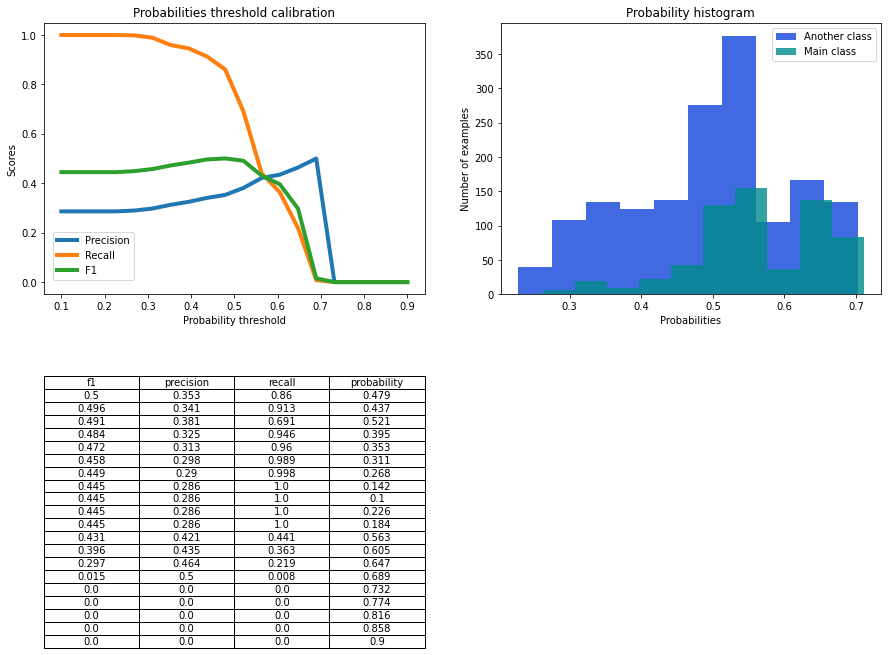

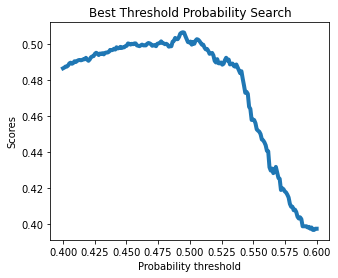

best threshold probability = 0.49447236180904525
0.5066539923954372
----------------------------------------------------------------------
f1 on valid set after calibrating = 0.5066539923954372
TRAIN

              precision    recall  f1-score   support

           0       0.83      0.47      0.60      3221
           1       0.40      0.79      0.53      1469

    accuracy                           0.57      4690
   macro avg       0.62      0.63      0.57      4690
weighted avg       0.70      0.57      0.58      4690

TEST

              precision    recall  f1-score   support

           0       0.86      0.42      0.57      1606
           1       0.37      0.83      0.51       644

    accuracy                           0.54      2250
   macro avg       0.61      0.63      0.54      2250
weighted avg       0.72      0.54      0.55      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               679  927
1               111  533


In [2219]:
# 3.11.4.калибровка
predict_probas = model_catb.predict_proba(X_test[importance_features])
show_proba_calibration_plots(predict_probas, y_test, 0.1, 0.9, 20)
predict2, threshold_prob = update_predict_by_prob(y_test, predict_probas, 0.4, 0.6, 200, score='f1', show_chart=True)
# print(f1_score(y_test, predict))
print(f1_score(y_test, predict2))

# 3.11.5. результаты
print(70*'-')
# print(f'f1 on valid set = {f1_score(y_test, predict)}')
print(f'f1 on valid set after calibrating = {f1_score(y_test, predict2)}')
get_classification_report(y_train_tom_CB, y_train_pred, y_test, predict2)

In [2220]:
X_tom_CB[importance_features]
y_tom_CB.value_counts()

0    4621
1    2113
Name: Credit Default, dtype: int64

In [2221]:
# 4.2. Обучение модели на полном датасете (Liniar Regression)

threshold_prob = 0.5178391959798996

model = model_lr
model.fit(X_tom_CB[lr_features], y_tom_CB)

predict_train_probas = model.predict_proba(X_tom_CB[lr_features])
predict_train = np.array([1 if x>=threshold_prob else 0 for x in predict_train_probas[:,1]])

print(' Final Model Liniar Regression')
print(70*'-')
print(f'accuracy on full train set = {accuracy_score(y_tom_CB, predict_train)}')
print(f'f1 on full train set = {f1_score(y_tom_CB, predict_train)}')
print(confusion_matrix(y_tom_CB, predict_train))
print(classification_report(y_tom_CB, predict_train))
print(70*'-')

y_pred_probas = model.predict_proba(df_test_new[lr_features])
y_pred = np.array([1 if x>=threshold_prob else 0 for x in y_pred_probas[:, 1]])
y_pred = pd.DataFrame(y_pred, columns=[TARGET_NAME])

print(y_pred.shape)
y_pred.value_counts()

 Final Model Liniar Regression
----------------------------------------------------------------------
accuracy on full train set = 0.5579150579150579
f1 on full train set = 0.5161709735088574
[[2169 2452]
 [ 525 1588]]
              precision    recall  f1-score   support

           0       0.81      0.47      0.59      4621
           1       0.39      0.75      0.52      2113

    accuracy                           0.56      6734
   macro avg       0.60      0.61      0.55      6734
weighted avg       0.68      0.56      0.57      6734

----------------------------------------------------------------------
(2500, 1)


Credit Default
1                 1492
0                 1008
dtype: int64

In [2222]:
filename = 'Navoyan_2810_catb.csv'
y_pred.to_csv(filename, index=None)

In [2223]:
# 4.2. Обучение модели на полном датасете (CAT_BOOST)

threshold_prob = 0.5165829145728643

model = model_catb
model.fit(X_tom_CB[importance_features], y_tom_CB)

predict_train_probas = model.predict_proba(X_tom_CB[importance_features])
predict_train = np.array([1 if x>=threshold_prob else 0 for x in predict_train_probas[:,1]])

print(' Final Model CAT-BOOST')
print(70*'-')
print(f'accuracy on full train set = {accuracy_score(y_tom_CB, predict_train)}')
print(f'f1 on full train set = {f1_score(y_tom_CB, predict_train)}')
print(confusion_matrix(y_tom_CB, predict_train))
print(classification_report(y_tom_CB, predict_train))
print(70*'-')

y_pred_probas = model.predict_proba(df_test_new[importance_features])
y_pred = np.array([1 if x>=threshold_prob else 0 for x in y_pred_probas[:, 1]])
y_pred = pd.DataFrame(y_pred, columns=[TARGET_NAME])

print(y_pred.shape)
y_pred.value_counts()

 Final Model CAT-BOOST
----------------------------------------------------------------------
accuracy on full train set = 0.581972081972082
f1 on full train set = 0.5347876384068748
[[2301 2320]
 [ 495 1618]]
              precision    recall  f1-score   support

           0       0.82      0.50      0.62      4621
           1       0.41      0.77      0.53      2113

    accuracy                           0.58      6734
   macro avg       0.62      0.63      0.58      6734
weighted avg       0.69      0.58      0.59      6734

----------------------------------------------------------------------
(2500, 1)


Credit Default
1                 1470
0                 1030
dtype: int64

In [2224]:
filename = 'Navoyan_2810_LR.csv'
y_pred.to_csv(filename, index=None)